In [1]:
import torch
from torch import nn
torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


Data folder path: D:\Programming\Projects\Facial_Emotion_Recognition\data
Random image path:..\data\train\neutral\Training_76335558.jpg
Image class:neutral
Image height:48
Image width: 48


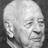

In [2]:
from pathlib import Path
from PIL import Image
import random

# go up one level to reach project root
image_path = Path("../data")

print(f"Data folder path: {image_path.resolve()}")

if not image_path.exists():
    raise FileNotFoundError(f"Data folder not found at {image_path.resolve()}")

# collect all jpgs (train/test/class/image.jpg)
image_path_list = list(image_path.glob("*/*/*.jpg"))

if not image_path_list:
    raise ValueError("No images found inside data folder")

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height:{img.height}")
print(f"Image width: {img.width}")
img


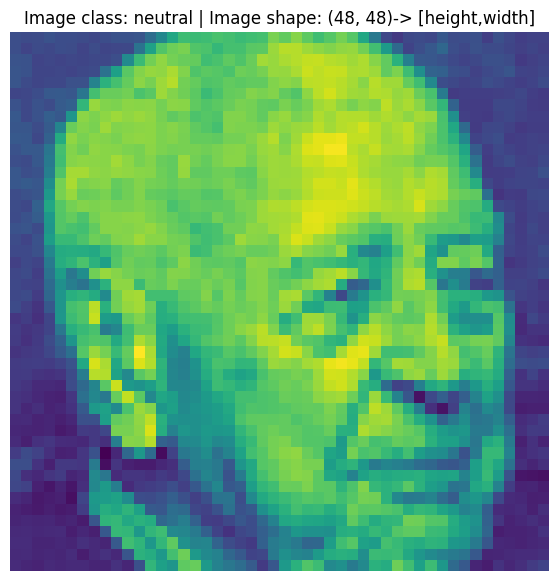

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}-> [height,width]")
plt.axis(False)

image_height = img_as_array.shape[0]
image_width = img_as_array.shape[1]

In [4]:
img_as_array.shape

(48, 48)

In [5]:
train_dir = image_path /"train"
test_dir = image_path/"test"

train_dir,test_dir

(WindowsPath('../data/train'), WindowsPath('../data/test'))

Transforming Data

In [6]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Training transformations (with mild augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <--- convert 1→3
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),         # small left-right flips
    transforms.ToTensor(),                          # convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                     std=(0.5, 0.5, 0.5))

])

# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <--- convert 1→3
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                     std=(0.5, 0.5, 0.5))

])

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [7]:
print("Length of training dataset:", len(train_data))
print("Length of test dataset:", len(test_data))

Length of training dataset: 28709
Length of test dataset: 7178


In [8]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, dropout_rate: float = 0.3):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 48x48 -> 24x24
            nn.Dropout2d(p=dropout_rate)  # dropout after conv block
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 24x24 -> 12x12
            nn.Dropout2d(p=dropout_rate)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*2*12*12, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  # regularize before final output
            nn.Linear(in_features=128, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [9]:
import torch
from torch import nn

class MediumCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [10]:
from re import L
def train_step(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device : torch.device = device):
  model.train()
  train_loss,train_acc = 0,0
  model.to(device)
  for batch,(X,y) in enumerate (data_loader):
    X, y = X.to(device), y.to(device)

    #forward pass
    y_pred = model(X)

    #calc loss
    loss=loss_fn(y_pred,y)
    train_loss +=loss.item()

    #optimizer zero grad
    optimizer.zero_grad()


    #loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

    #calc accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc +=(y_pred_class==y).sum().item()/len(y_pred)

  #calc loss and acc per epoch and print out whats happeneing
  train_loss /=len(data_loader)
  train_acc /=len(data_loader)
  return train_loss,train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model:torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss,test_acc = 0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():

    for X,y in (data_loader):
      X,y = X.to(device),y.to(device)

      #forward pass
      test_pred = model(X)

      #calc loss
      loss = loss_fn(test_pred,y)
      test_loss+=loss.item()

      #calc acc
      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    #adjust metrics and print out
    test_loss/=len(data_loader)
    test_acc /=len(data_loader)
    return test_loss,test_acc

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
          save_path: str = "best_model.pth",
          patience: int = 5):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    best_test_loss = float("inf")
    patience_counter = 0

    # Learning rate scheduler (reduce LR by half if no improvement)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    model.to(device)

    print(f"🚀 Training started on {device} for {epochs} epochs (patience={patience})")

    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_loss, test_acc = test_step(
            data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            device=device
        )

        # Scheduler step
        scheduler.step(test_loss)

        # Print progress
        print(f"Epoch: {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # --- Checkpoint saving ---
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"✅ Saved new best model with Test Loss: {best_test_loss:.4f}")
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience counter: {patience_counter}/{patience}")

        # --- Early stopping check ---
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch}")
            break

        # Save metrics
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    print(f"✅ Training complete. Best Test Loss: {best_test_loss:.4f}")
    return results


In [18]:

model_1 = TinyVGG(input_shape =3,
                   hidden_units =32,
                   output_shape = 7).to(device)
print(model_1)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.3, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
NUM_EPOCHS = 30

loss_fn = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(params = model_1.parameters(),
                              lr = 0.001)
start_time = time.time()

model_1_results = train(model = model_1,
                        train_dataloader = train_loader,
                        test_dataloader = test_loader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = time.time()
print(f"Total training time: {end_time-start_time: .3f} seconds")

🚀 Training started on cuda for 30 epochs (patience=5)


  3%|▎         | 1/30 [05:15<2:32:32, 315.62s/it]

Epoch: 1/30 | Train Loss: 1.7336 | Train Acc: 0.2975 | Test Loss: 1.5483 | Test Acc: 0.4044 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.5483


  7%|▋         | 2/30 [09:23<2:08:41, 275.75s/it]

Epoch: 2/30 | Train Loss: 1.5232 | Train Acc: 0.4071 | Test Loss: 1.3804 | Test Acc: 0.4684 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.3804


 10%|█         | 3/30 [09:53<1:13:34, 163.51s/it]

Epoch: 3/30 | Train Loss: 1.4055 | Train Acc: 0.4602 | Test Loss: 1.3043 | Test Acc: 0.5015 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.3043


 13%|█▎        | 4/30 [10:23<47:59, 110.75s/it]  

Epoch: 4/30 | Train Loss: 1.3370 | Train Acc: 0.4905 | Test Loss: 1.2437 | Test Acc: 0.5233 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.2437


 17%|█▋        | 5/30 [10:55<34:23, 82.53s/it] 

Epoch: 5/30 | Train Loss: 1.2848 | Train Acc: 0.5088 | Test Loss: 1.2090 | Test Acc: 0.5269 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.2090


 20%|██        | 6/30 [11:25<25:51, 64.64s/it]

Epoch: 6/30 | Train Loss: 1.2460 | Train Acc: 0.5214 | Test Loss: 1.1833 | Test Acc: 0.5398 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1833


 23%|██▎       | 7/30 [11:50<19:47, 51.64s/it]

Epoch: 7/30 | Train Loss: 1.2118 | Train Acc: 0.5361 | Test Loss: 1.1822 | Test Acc: 0.5452 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1822


 27%|██▋       | 8/30 [12:23<16:46, 45.76s/it]

Epoch: 8/30 | Train Loss: 1.1899 | Train Acc: 0.5465 | Test Loss: 1.1501 | Test Acc: 0.5592 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1501


 30%|███       | 9/30 [12:58<14:49, 42.34s/it]

Epoch: 9/30 | Train Loss: 1.1678 | Train Acc: 0.5560 | Test Loss: 1.1383 | Test Acc: 0.5593 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1383


 33%|███▎      | 10/30 [13:34<13:25, 40.28s/it]

Epoch: 10/30 | Train Loss: 1.1388 | Train Acc: 0.5642 | Test Loss: 1.1269 | Test Acc: 0.5647 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1269


 37%|███▋      | 11/30 [13:59<11:18, 35.73s/it]

Epoch: 11/30 | Train Loss: 1.1276 | Train Acc: 0.5721 | Test Loss: 1.1227 | Test Acc: 0.5731 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1227


 40%|████      | 12/30 [14:29<10:12, 34.05s/it]

Epoch: 12/30 | Train Loss: 1.1063 | Train Acc: 0.5794 | Test Loss: 1.1171 | Test Acc: 0.5727 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1171


 43%|████▎     | 13/30 [15:00<09:20, 32.96s/it]

Epoch: 13/30 | Train Loss: 1.0905 | Train Acc: 0.5829 | Test Loss: 1.1124 | Test Acc: 0.5825 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1124


 47%|████▋     | 14/30 [15:28<08:25, 31.57s/it]

Epoch: 14/30 | Train Loss: 1.0725 | Train Acc: 0.5926 | Test Loss: 1.1113 | Test Acc: 0.5818 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1113


 50%|█████     | 15/30 [15:55<07:30, 30.00s/it]

Epoch: 15/30 | Train Loss: 1.0546 | Train Acc: 0.6018 | Test Loss: 1.1147 | Test Acc: 0.5799 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 53%|█████▎    | 16/30 [16:25<07:03, 30.25s/it]

Epoch: 16/30 | Train Loss: 1.0373 | Train Acc: 0.6055 | Test Loss: 1.1091 | Test Acc: 0.5781 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1091


 57%|█████▋    | 17/30 [16:51<06:16, 28.94s/it]

Epoch: 17/30 | Train Loss: 1.0278 | Train Acc: 0.6098 | Test Loss: 1.1182 | Test Acc: 0.5787 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 60%|██████    | 18/30 [17:17<05:35, 27.94s/it]

Epoch: 18/30 | Train Loss: 1.0214 | Train Acc: 0.6118 | Test Loss: 1.1082 | Test Acc: 0.5854 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1082


 63%|██████▎   | 19/30 [17:48<05:18, 28.99s/it]

Epoch: 19/30 | Train Loss: 0.9935 | Train Acc: 0.6192 | Test Loss: 1.1154 | Test Acc: 0.5887 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 67%|██████▋   | 20/30 [18:19<04:55, 29.54s/it]

Epoch: 20/30 | Train Loss: 0.9895 | Train Acc: 0.6232 | Test Loss: 1.1168 | Test Acc: 0.5858 | LR: 0.001000
⏳ No improvement. Patience counter: 2/5


 70%|███████   | 21/30 [18:50<04:28, 29.88s/it]

Epoch: 21/30 | Train Loss: 0.9860 | Train Acc: 0.6262 | Test Loss: 1.0960 | Test Acc: 0.5925 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.0960


 73%|███████▎  | 22/30 [19:21<04:01, 30.16s/it]

Epoch: 22/30 | Train Loss: 0.9664 | Train Acc: 0.6339 | Test Loss: 1.1113 | Test Acc: 0.5847 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 77%|███████▋  | 23/30 [19:51<03:31, 30.17s/it]

Epoch: 23/30 | Train Loss: 0.9554 | Train Acc: 0.6347 | Test Loss: 1.1095 | Test Acc: 0.5851 | LR: 0.001000
⏳ No improvement. Patience counter: 2/5


 80%|████████  | 24/30 [20:22<03:02, 30.37s/it]

Epoch: 24/30 | Train Loss: 0.9475 | Train Acc: 0.6368 | Test Loss: 1.1044 | Test Acc: 0.5914 | LR: 0.001000
⏳ No improvement. Patience counter: 3/5


 83%|████████▎ | 25/30 [20:52<02:31, 30.39s/it]

Epoch: 25/30 | Train Loss: 0.9358 | Train Acc: 0.6417 | Test Loss: 1.1228 | Test Acc: 0.5858 | LR: 0.001000
⏳ No improvement. Patience counter: 4/5


 83%|████████▎ | 25/30 [21:23<04:16, 51.34s/it]

Epoch: 26/30 | Train Loss: 0.9227 | Train Acc: 0.6476 | Test Loss: 1.1213 | Test Acc: 0.5908 | LR: 0.001000
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 26
✅ Training complete. Best Test Loss: 1.0960
Total training time:  1283.402 seconds


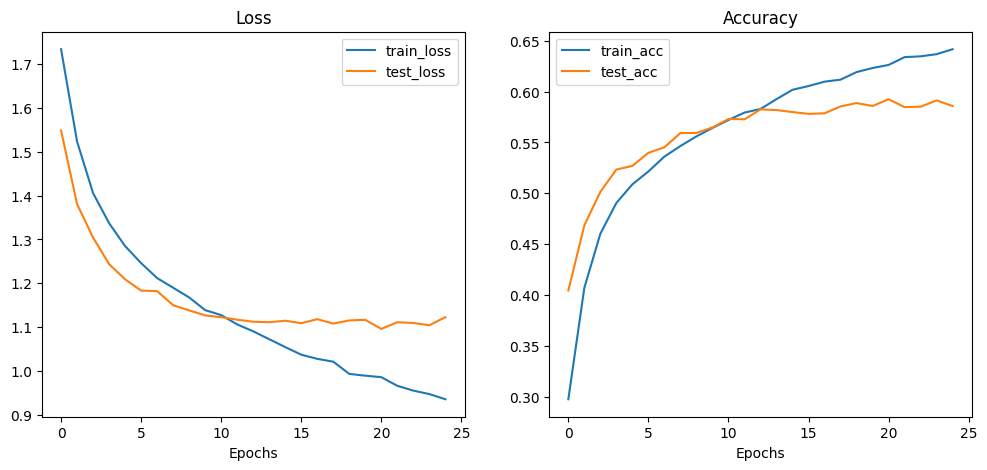

In [20]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: dict):
  """
  Returns separate loss curves for training and test metrics.
  """
  #get loss values from results
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  #get acc values from results
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  #figure out number of epochs
  epochs = range(len(results["train_loss"]))

  #plot loss
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot acc
  plt.subplot(1,2,2)
  plt.plot(epochs,train_acc,label="train_acc")
  plt.plot(epochs,test_acc,label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()
plot_loss_curves(model_1_results)


MediumCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inplace

  3%|▎         | 1/30 [00:35<17:21, 35.90s/it]

Epoch: 1/30 | Train Loss: 1.7956 | Train Acc: 0.2669 | Test Loss: 1.5654 | Test Acc: 0.3569 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.5654


  7%|▋         | 2/30 [01:08<15:57, 34.19s/it]

Epoch: 2/30 | Train Loss: 1.5812 | Train Acc: 0.3697 | Test Loss: 1.4224 | Test Acc: 0.4572 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.4224


 10%|█         | 3/30 [01:38<14:30, 32.26s/it]

Epoch: 3/30 | Train Loss: 1.5018 | Train Acc: 0.4075 | Test Loss: 1.3908 | Test Acc: 0.4561 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.3908


 13%|█▎        | 4/30 [02:08<13:35, 31.36s/it]

Epoch: 4/30 | Train Loss: 1.4536 | Train Acc: 0.4280 | Test Loss: 1.3359 | Test Acc: 0.4933 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.3359


 17%|█▋        | 5/30 [02:39<12:55, 31.01s/it]

Epoch: 5/30 | Train Loss: 1.4340 | Train Acc: 0.4330 | Test Loss: 1.3173 | Test Acc: 0.4825 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.3173


 20%|██        | 6/30 [03:09<12:17, 30.73s/it]

Epoch: 6/30 | Train Loss: 1.4046 | Train Acc: 0.4456 | Test Loss: 1.2692 | Test Acc: 0.5112 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.2692


 23%|██▎       | 7/30 [03:40<11:49, 30.85s/it]

Epoch: 7/30 | Train Loss: 1.3871 | Train Acc: 0.4531 | Test Loss: 1.2558 | Test Acc: 0.5157 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.2558


 27%|██▋       | 8/30 [04:09<11:02, 30.12s/it]

Epoch: 8/30 | Train Loss: 1.3704 | Train Acc: 0.4573 | Test Loss: 1.2613 | Test Acc: 0.5162 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 30%|███       | 9/30 [04:38<10:30, 30.00s/it]

Epoch: 9/30 | Train Loss: 1.3579 | Train Acc: 0.4665 | Test Loss: 1.2489 | Test Acc: 0.5177 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.2489


 33%|███▎      | 10/30 [05:08<09:59, 29.99s/it]

Epoch: 10/30 | Train Loss: 1.3504 | Train Acc: 0.4681 | Test Loss: 1.2009 | Test Acc: 0.5356 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.2009


 37%|███▋      | 11/30 [05:39<09:34, 30.23s/it]

Epoch: 11/30 | Train Loss: 1.3384 | Train Acc: 0.4735 | Test Loss: 1.2241 | Test Acc: 0.5235 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 40%|████      | 12/30 [06:09<09:03, 30.17s/it]

Epoch: 12/30 | Train Loss: 1.3320 | Train Acc: 0.4766 | Test Loss: 1.2248 | Test Acc: 0.5321 | LR: 0.001000
⏳ No improvement. Patience counter: 2/5


 43%|████▎     | 13/30 [06:40<08:34, 30.28s/it]

Epoch: 13/30 | Train Loss: 1.3219 | Train Acc: 0.4801 | Test Loss: 1.1975 | Test Acc: 0.5413 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1975


 47%|████▋     | 14/30 [07:10<08:07, 30.44s/it]

Epoch: 14/30 | Train Loss: 1.3096 | Train Acc: 0.4858 | Test Loss: 1.1792 | Test Acc: 0.5535 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1792


 50%|█████     | 15/30 [07:41<07:38, 30.56s/it]

Epoch: 15/30 | Train Loss: 1.2970 | Train Acc: 0.4901 | Test Loss: 1.1660 | Test Acc: 0.5503 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1660


 53%|█████▎    | 16/30 [08:12<07:08, 30.61s/it]

Epoch: 16/30 | Train Loss: 1.2905 | Train Acc: 0.4951 | Test Loss: 1.1638 | Test Acc: 0.5557 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1638


 57%|█████▋    | 17/30 [08:43<06:40, 30.83s/it]

Epoch: 17/30 | Train Loss: 1.2865 | Train Acc: 0.4955 | Test Loss: 1.1523 | Test Acc: 0.5615 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1523


 60%|██████    | 18/30 [09:14<06:09, 30.82s/it]

Epoch: 18/30 | Train Loss: 1.2813 | Train Acc: 0.5006 | Test Loss: 1.1581 | Test Acc: 0.5520 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 63%|██████▎   | 19/30 [09:45<05:39, 30.85s/it]

Epoch: 19/30 | Train Loss: 1.2728 | Train Acc: 0.5009 | Test Loss: 1.1525 | Test Acc: 0.5567 | LR: 0.001000
⏳ No improvement. Patience counter: 2/5


 67%|██████▋   | 20/30 [10:16<05:08, 30.89s/it]

Epoch: 20/30 | Train Loss: 1.2658 | Train Acc: 0.5067 | Test Loss: 1.1452 | Test Acc: 0.5729 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1452


 70%|███████   | 21/30 [10:47<04:38, 30.97s/it]

Epoch: 21/30 | Train Loss: 1.2518 | Train Acc: 0.5138 | Test Loss: 1.1624 | Test Acc: 0.5600 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 73%|███████▎  | 22/30 [11:12<03:52, 29.08s/it]

Epoch: 22/30 | Train Loss: 1.2389 | Train Acc: 0.5181 | Test Loss: 1.1324 | Test Acc: 0.5746 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1324


 77%|███████▋  | 23/30 [11:35<03:10, 27.22s/it]

Epoch: 23/30 | Train Loss: 1.2334 | Train Acc: 0.5250 | Test Loss: 1.1354 | Test Acc: 0.5730 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 80%|████████  | 24/30 [11:57<02:35, 25.88s/it]

Epoch: 24/30 | Train Loss: 1.2267 | Train Acc: 0.5240 | Test Loss: 1.1206 | Test Acc: 0.5745 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1206


 83%|████████▎ | 25/30 [12:20<02:04, 24.89s/it]

Epoch: 25/30 | Train Loss: 1.2180 | Train Acc: 0.5269 | Test Loss: 1.1254 | Test Acc: 0.5772 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 87%|████████▋ | 26/30 [12:42<01:36, 24.12s/it]

Epoch: 26/30 | Train Loss: 1.2216 | Train Acc: 0.5280 | Test Loss: 1.1217 | Test Acc: 0.5764 | LR: 0.001000
⏳ No improvement. Patience counter: 2/5


 90%|█████████ | 27/30 [13:05<01:10, 23.56s/it]

Epoch: 27/30 | Train Loss: 1.2082 | Train Acc: 0.5361 | Test Loss: 1.1110 | Test Acc: 0.5820 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1110


 93%|█████████▎| 28/30 [13:27<00:46, 23.20s/it]

Epoch: 28/30 | Train Loss: 1.1899 | Train Acc: 0.5433 | Test Loss: 1.1253 | Test Acc: 0.5778 | LR: 0.001000
⏳ No improvement. Patience counter: 1/5


 97%|█████████▋| 29/30 [13:49<00:22, 22.92s/it]

Epoch: 29/30 | Train Loss: 1.1794 | Train Acc: 0.5497 | Test Loss: 1.1012 | Test Acc: 0.5854 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1012


100%|██████████| 30/30 [14:12<00:00, 28.40s/it]

Epoch: 30/30 | Train Loss: 1.1695 | Train Acc: 0.5536 | Test Loss: 1.1010 | Test Acc: 0.5809 | LR: 0.001000
✅ Saved new best model with Test Loss: 1.1010
✅ Training complete. Best Test Loss: 1.1010
Total training time:  852.136 seconds


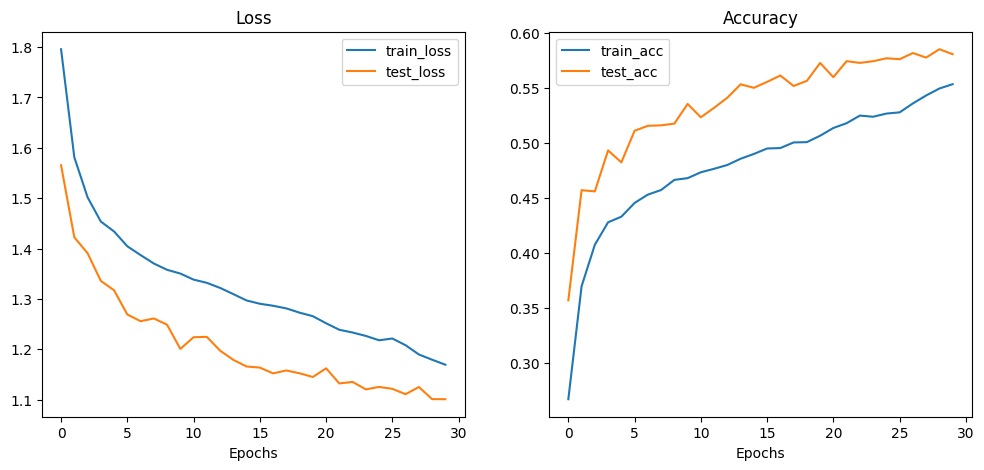

In [21]:
model_2 = MediumCNN(input_channels=3, num_classes=7).to(device)
print(model_2)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
NUM_EPOCHS = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
start_time = time.time()
model_2_results = train(model=model_2,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device,
                        save_path="best_model_2.pth")
end_time = time.time()
print(f"Total training time: {end_time - start_time: .3f} seconds")
plot_loss_curves(model_2_results)


In [22]:
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path

# ----------------------------
# 1. Model and device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate your model (same architecture you trained)
model1 = TinyVGG(input_shape=3, hidden_units=32, output_shape=7).to(device)
model2 = MediumCNN(input_channels=3, num_classes=7).to(device)

# Load the trained weights
model1.load_state_dict(torch.load("best_model.pth", map_location=device))
model1.eval()

model2.load_state_dict(torch.load("best_model_2.pth", map_location=device))
model2.eval()

# Class names (adjust these to match your dataset)
class_names = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# ----------------------------
# 2. Define same transform as test data
# ----------------------------
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# ----------------------------
# 3. Predict on all images in folder
# ----------------------------
images_folder = Path(r"D:\Programming\Projects\Facial_Emotion_Recognition\images")  # your folder path

# Loop through all image files
for img_path in images_folder.glob("*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]:
        # Load image
        img = Image.open(img_path).convert("RGB")
        # Apply transforms
        img_tensor = transform(img).unsqueeze(0).to(device)
        # Predict
        with torch.inference_mode():
            output1 = model1(img_tensor)
            pred_class1 = torch.argmax(output1, dim=1).item()

            output2 = model2(img_tensor)
            pred_class2 = torch.argmax(output2, dim=1).item()

        # Print
        print(f"{img_path.name} : Model1: {class_names[pred_class1]} | Model2: {class_names[pred_class2]}")
    else:
        print(f"Skipped {img_path.name}, not a valid image file.")


angry.jpeg : Model1: angry | Model2: angry
fear.jpg : Model1: fear | Model2: fear
fear2.jpg : Model1: sad | Model2: fear
happy.jpeg : Model1: happy | Model2: happy
neutral.jpg : Model1: happy | Model2: happy
sad.jpg : Model1: sad | Model2: fear
surprise.jpeg : Model1: surprise | Model2: fear


In [23]:
from pathlib import Path
print("Current working directory:", Path.cwd())
print("Images folder exists:", Path("images").exists())


Current working directory: d:\Programming\Projects\Facial_Emotion_Recognition\model
Images folder exists: False


## Realtime Monitoring

In [29]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# -----------------------------
# Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Running on {device}")

# Load both models
model1 = TinyVGG(input_shape=3, hidden_units=32, output_shape=7).to(device)
model1.load_state_dict(torch.load("best_model.pth", map_location=device))
model1.eval()

model2 = MediumCNN(input_channels=3, num_classes=7).to(device)
model2.load_state_dict(torch.load("best_model_2.pth", map_location=device))
model2.eval()

# Emotion labels
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Transform (same as training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# -----------------------------
# Initialize webcam and face detector
# -----------------------------
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("❌ Error: Could not open webcam.")
    exit()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

print("🎥 Starting real-time emotion detection... Press 'q' to quit.")

# For smoother detection
last_face = None
missed_frames = 0
MAX_MISSES = 10  # Keep last known face for 10 frames if detection fails

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(60, 60))

    # Keep tracking last face for smoother performance
    if len(faces) > 0:
        last_face = faces[0]
        missed_frames = 0
    elif last_face is not None and missed_frames < MAX_MISSES:
        faces = [last_face]
        missed_frames += 1
    else:
        faces = []
        last_face = None

    for (x, y, w, h) in faces:
        # Extract and preprocess face
        face_img = frame[y:y+h, x:x+w]
        face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        img_tensor = transform(face_pil).unsqueeze(0).to(device)

        # Predictions from both models
        with torch.inference_mode():
            out1 = torch.softmax(model1(img_tensor), dim=1)
            out2 = torch.softmax(model2(img_tensor), dim=1)
            # Average predictions for smoother confidence
            pred = (out1 + out2) / 2
            pred_class = torch.argmax(pred, dim=1).item()
            confidence = torch.max(pred).item()

        # Draw bounding box and label
        label = f"{class_names[pred_class]} ({confidence*100:.1f}%)"
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)
        cv2.putText(frame, label, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow("Real-Time Facial Expression Monitor", frame)

    # Quit on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
print("🛑 Stopped.")


🔥 Running on cuda
🎥 Starting real-time emotion detection... Press 'q' to quit.
🛑 Stopped.
